In [1]:
library('magrittr')
library('tibble')
library('dplyr')
library('tidyr')
library('ggplot2')
library('RColorBrewer')
library('readr')
library('broom')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



In [2]:
bx_data <-
    read_csv(
        'preprints.csv',
        col_types=cols(
            `is_revision`=col_factor(levels=c('True', 'False')),
            `master_id`=col_character(),
            `node_id`=col_character(),
            `preprint_type`=col_factor(levels=c('','Confirmatory Results', 'Contradictory Results', 'Evolutionary Biology', 'Genomics', 'N/A', 'New Results', 'Regular Article', 'Withdrawn')),
            `pub_date`=col_character(),
            `title`=col_character(),
            `version_id`=col_character(),
            .default=col_number()
        )
    ) %>%
    mutate(
        `pub_date_combined` = factor((`pub_date_year` * 100) + `pub_date_month`),
        `post_rev` = if_else(`is_revision` == 'True', "Revised", "Unique")
    )


bx_data %>% head

is_revision,master_id,node_id,preprint_type,pub_date,pub_date_day,pub_date_month,pub_date_year,title,version_id,pub_date_combined,post_rev
True,000026,2293,New Results,"September 08, 2014",8,9,2014,A Population Genetic Signature of Polygenic Local Adaptation,000026v2,201409,Revised
True,000042,266,New Results,"December 01, 2013",1,12,2013,Routes for breaching and protecting genetic privacy,000042v3,201312,Revised
False,000067,110,New Results,"November 07, 2013",7,11,2013,Genetics of single-cell protein abundance variation in large yeast populations,000067v1,201311,Unique
True,000075,960,New Results,"March 30, 2014",30,3,2014,A Scalable Formulation for Engineering Combination Therapies for Evolutionary Dynamics of Disease,000075v2,201403,Revised
False,000091,112,New Results,"November 07, 2013",7,11,2013,Designing Robustness to Temperature in a Feedforward Loop Circuit,000091v1,201311,Unique
False,000109,113,New Results,"November 07, 2013",7,11,2013,Speciation and introgression between Mimulus nasutus and Mimulus guttatus,000109v1,201311,Unique


In [3]:
org_opts <- options()

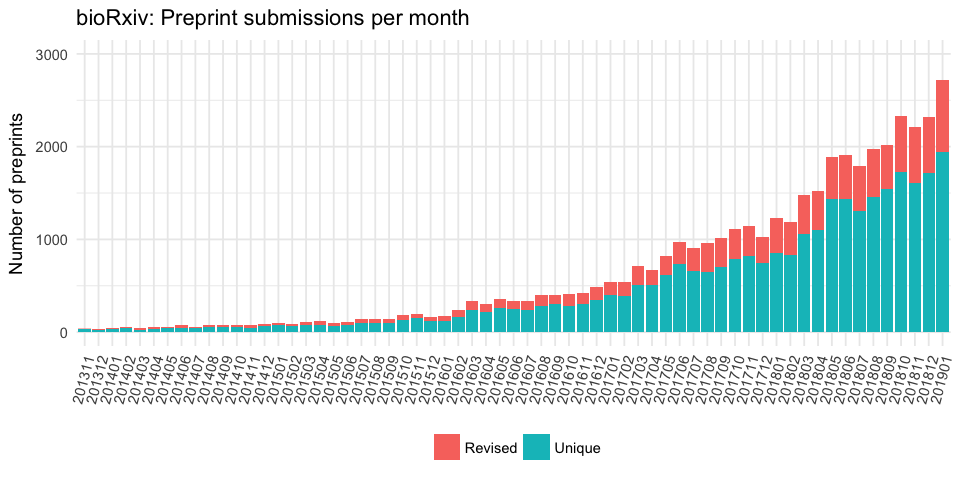

In [4]:
options(repr.plot.width=8, repr.plot.height=4)

sum_plot <-
    bx_data %>%
    filter(!(`pub_date_year` == 2019 & `pub_date_month` == 2)) %>%
    group_by(`pub_date_combined`, `post_rev`) %>%
    summarize(`pub_count` = n()) %>%
    ungroup() %>%
    ggplot(aes(x=`pub_date_combined`, y=`pub_count`, fill=`post_rev`)) +
        geom_col() +
        theme_minimal() +
        theme(
            axis.title.x=element_blank(),
            axis.text.x=element_text(angle=75, hjust=1),
            legend.position="bottom"
        ) +
        ylab("Number of preprints") +
        ggtitle('bioRxiv: Preprint submissions per month') +
        guides(fill=guide_legend(title="")) +
        ylim(0, 3000)

sum_plot

In [5]:
png('num-of-preprints-per-month.png', height=400, width=800)
sum_plot
dev.off()

pdf 
  2

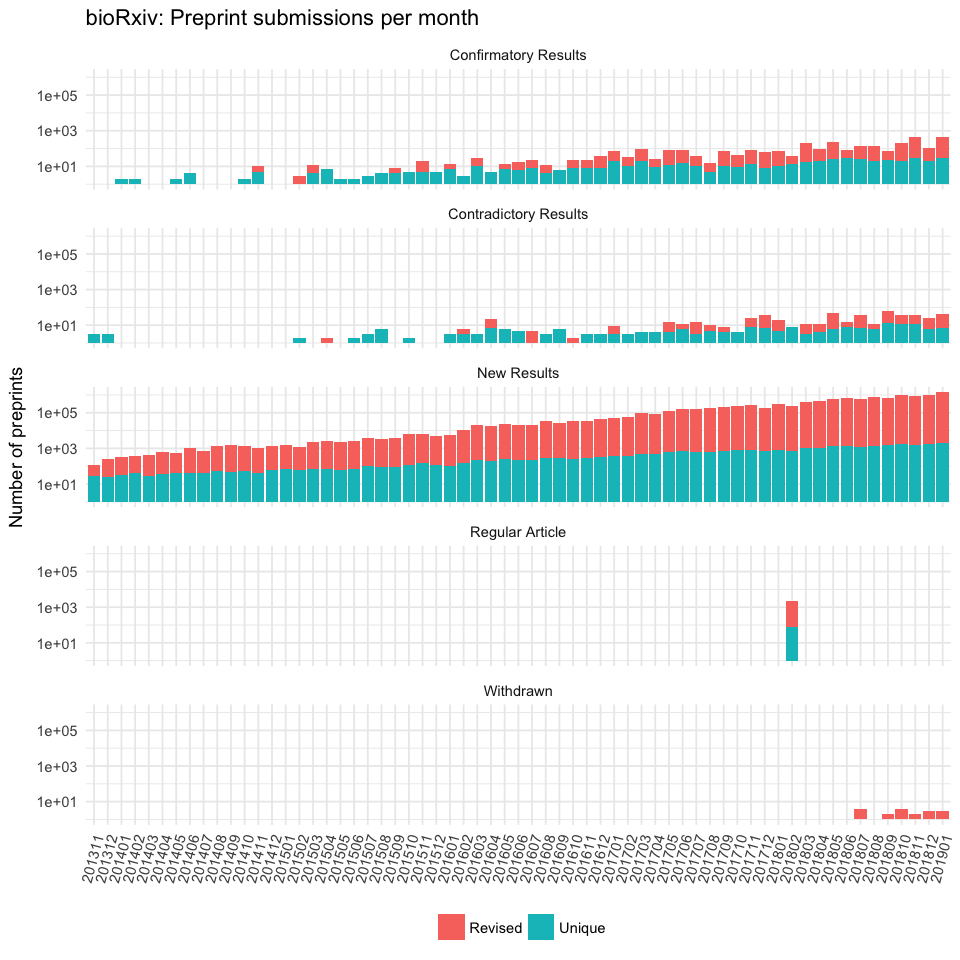

In [6]:
options(repr.plot.width=8, repr.plot.height=8)

sum_plot_2 <-
    bx_data %>%
    filter(!(`pub_date_year` == 2019 & `pub_date_month` == 2)) %>%
    group_by(`pub_date_combined`, `post_rev`, `preprint_type`) %>%
    summarize(`pub_count` = n()) %>%
    ungroup() %>%
    filter(
        `preprint_type` %in% c('Withdrawn',
                              'Regular Article',
                              'Contradictory Results',
                              'Confirmatory Results',
                              'New Results')
    ) %>%
    ggplot(aes(x=`pub_date_combined`, y=`pub_count`, fill=`post_rev`)) +
        geom_col() +
        theme_minimal() +
        theme(
            axis.title.x=element_blank(),
            axis.text.x=element_text(angle=75, hjust=1),
            legend.position="bottom"
        ) +
        ylab("Number of preprints") +
        ggtitle('bioRxiv: Preprint submissions per month') +
        guides(fill=guide_legend(title="")) +
        facet_wrap(~`preprint_type`, ncol=1) +
        scale_y_log10()

sum_plot_2

In [7]:
png('num-of-preprints-per-month-per-category.png', height=800, width=800)
sum_plot_2
dev.off()

pdf 
  2

In [8]:
bx_month <-
    bx_data %>%
    filter(!(`pub_date_year` == 2019 & `pub_date_month` == 2)) %>%
    group_by(`pub_date_combined`, `pub_date_month`) %>%
    summarize(`pub_count` = n())

bx_month %>% head

pub_date_combined,pub_date_month,pub_count
201311,11,37
201312,12,38
201401,1,44
201402,2,51
201403,3,43
201404,4,53


In [9]:
bx_month$dummy <- 1:nrow(bx_month)

bx_fit <-
    bx_month %>%
    lm(formula=log(`pub_count`)~`dummy`)

bx_fit %>% summary

bx_fit %>% tidy

bx_month$`fitted` <- exp(predict.lm(bx_fit))


Call:
lm(formula = log(pub_count) ~ dummy, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27956 -0.07015 -0.00361  0.08283  0.25951 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.5093942  0.0304718  115.17   <2e-16 ***
dummy       0.0708086  0.0008279   85.53   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1195 on 61 degrees of freedom
Multiple R-squared:  0.9917,	Adjusted R-squared:  0.9916 
F-statistic:  7315 on 1 and 61 DF,  p-value: < 2.2e-16


term,estimate,std.error,statistic,p.value
(Intercept),3.50939415,0.030471776,115.16868,4.558738e-73
dummy,0.07080857,0.000827907,85.52721,3.114845e-65


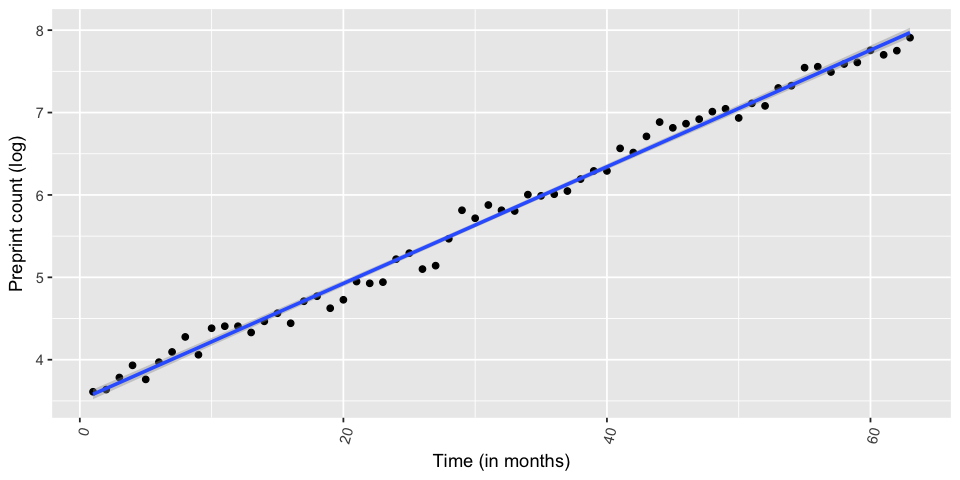

In [10]:
options(repr.plot.width=8, repr.plot.height=4)

bx_month %>%
    ggplot(aes(x=`dummy`, y=log(`pub_count`))) +
        geom_point() +
        geom_smooth(method="lm") +
        theme(
            axis.text.x=element_text(angle=75, hjust=1)
        ) +
        xlab('Time (in months)') +
        ylab('Preprint count (log)')

In [11]:
bx_month %>%
    mutate(`pub_count_diff` = (`pub_count` - `fitted`) / `pub_count`) %>%
    head()

pub_date_combined,pub_date_month,pub_count,dummy,fitted,pub_count_diff
201311,11,37,1,35.88081,0.03024827
201312,12,38,2,38.51360,-0.01351567
201401,1,44,3,41.33956,0.06046458
201402,2,51,4,44.37288,0.12994355
201403,3,43,5,47.62877,-0.10764586
201404,4,53,6,51.12357,0.03540438


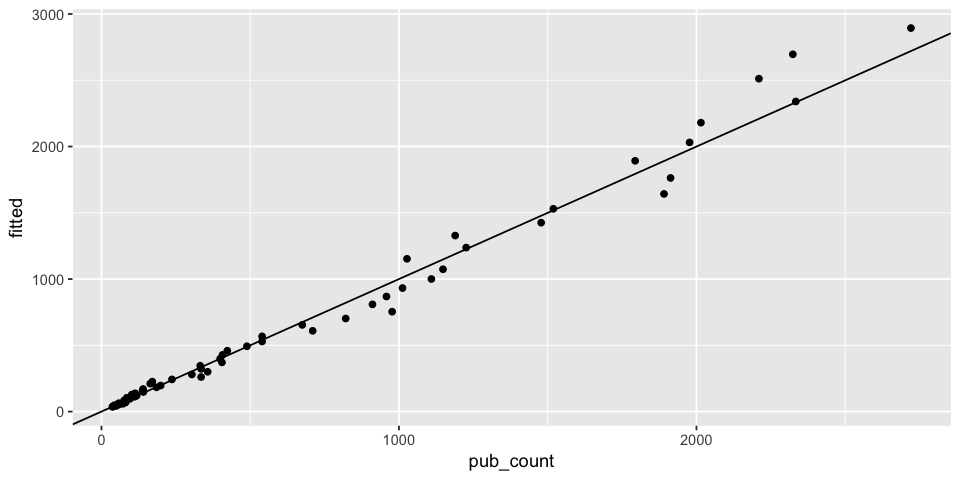

In [12]:
bx_month %>%
    mutate(`pub_count_diff` = (`pub_count` - `fitted`) / `pub_count`) %>%
    ggplot(aes(x=`pub_count`, y=`fitted`)) +
        geom_point() +
        geom_abline(slope=1)

In [13]:
bx_month$`month` <- factor(bx_month$`pub_date_month`, labels=month.abb)

In [14]:
bx_month %>% head

pub_date_combined,pub_date_month,pub_count,dummy,fitted,month
201311,11,37,1,35.88081,Nov
201312,12,38,2,38.51360,Dec
201401,1,44,3,41.33956,Jan
201402,2,51,4,44.37288,Feb
201403,3,43,5,47.62877,Mar
201404,4,53,6,51.12357,Apr


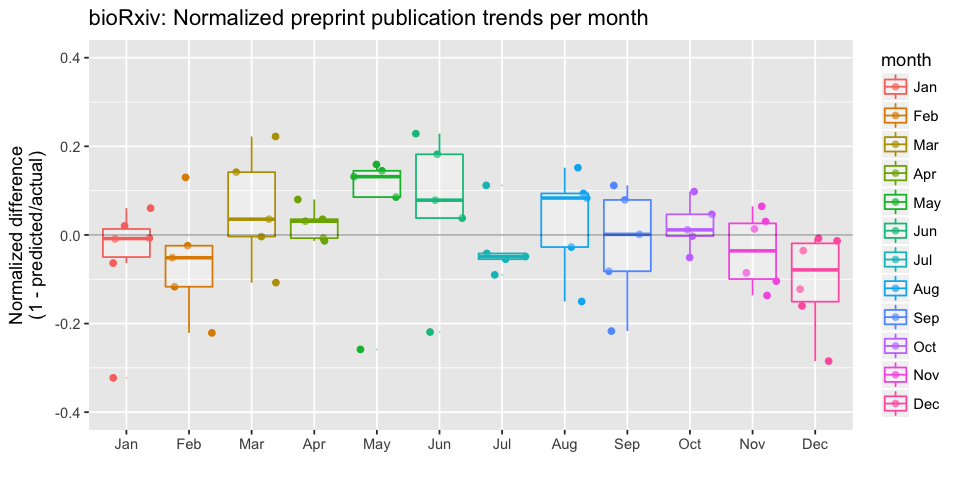

In [15]:
monthly_trends <- 
    bx_month %>%
    mutate(
        `pub_count_diff` = (`pub_count` - `fitted`) / `pub_count`
    ) %>%
    ggplot(aes(x=`month`,
               y=`pub_count_diff`,
               group=`month`,
               color=`month`)) +
        geom_jitter() +
        geom_boxplot(alpha=.3, outlier.size=0) +
        geom_hline(yintercept=0, alpha=.3) +
        xlab('') +
        ylab('Normalized difference\n(1 - predicted/actual)') +
        ylim(-.4, .4) +
        ggtitle('bioRxiv: Normalized preprint publication trends per month ')

monthly_trends

In [17]:
png('monthly-trends.png', height=400, width=800)
monthly_trends
dev.off()

pdf 
  2